In [39]:
# magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb
from tqdm import tqdm
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})

In [41]:
# Custom functions and tools 

import sys
sys.path.insert(1, '../../dipper')

import tools as my_tools
import dipper as dip_pipeline
import models as dip_models
from evaluate import evaluate as evaluate
from gpmcmc import model_gp

In [4]:
%%time
# load lite version of Gaia DR3 for quick cone searches
gaia_lite = lsdb.read_hipscat("/epyc/data3/hipscat/test_catalogs/gaia_symbolic", columns=['ra',
                                                                                         'dec', 
                                                                                     "parallax", 
                                                                                         "phot_g_mean_mag"])
#Load ZTF, Gaia, and ZTF sources hipscats # note data3/ for epyc
gaia = lsdb.read_hipscat("/epyc/data3/hipscat/test_catalogs/gaia_symbolic", 
                        columns=['ra', 'dec', 'parallax', 'parallax_over_error', 
                                'bp_rp', 'solution_id', 
                                'source_id', 
                                'pmra', 'pmra_error', 
                                'pmdec', 'pmdec_error', 
                                'parallax_error', 
                                'phot_g_mean_mag', 
                                'l', 'b', 'non_single_star', 
                                'classprob_dsc_combmod_galaxy', 
                                'classprob_dsc_combmod_star', 
                                 'in_qso_candidates',
                                'teff_gspphot', 'teff_gspphot_upper', 'teff_gspphot_lower',
                                'logg_gspphot', 'logg_gspphot_lower', 'logg_gspphot_upper',
                                'mh_gspphot','mh_gspphot_lower', 'mh_gspphot_upper',
                                'distance_gspphot', 'distance_gspphot_lower','distance_gspphot_upper',
                                'azero_gspphot', 'azero_gspphot_lower', 'azero_gspphot_upper', 'ag_gspphot', 
                                 'ebpminrp_gspphot', 'ebpminrp_gspphot_lower', 'ebpminrp_gspphot_upper',
                                'Norder', 'Npix', 'Dir'])

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

CPU times: user 56.8 s, sys: 6.46 s, total: 1min 3s
Wall time: 1min 4s


In [5]:
%%time
# load pre-saved FG sample
_sample_hips = lsdb.read_hipscat("/astro/users/atzanida/epyc/ssd/users/atzanida/tmp/data_files/fg_sample")

CPU times: user 2.39 s, sys: 118 ms, total: 2.51 s
Wall time: 2.49 s


In [966]:
ztf_sources

,index,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,catflags,fieldID,mag,magerr,mjd,rcID,band,Norder,Dir,Npix
npartitions=311037,,,,,,,,,,,,,,,,,,,,,,,
0,int64,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int16,int16,float32,float32,float64,int16,string,int32,int32,int32
281474976710656,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13834987686537986048,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
# do not run
%%time
# crossmatch ZTF + Gaia
_all_sky_object = gaia.crossmatch(ztf).query(
    "nobs_g_ztf_dr14 > 50 and nobs_r_ztf_dr14 > 50 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5")
# ran at 415

CPU times: user 943 ms, sys: 36.4 ms, total: 979 ms
Wall time: 983 ms


In [6]:
# do not run
%%time
_all_sky_object = _all_sky_object.compute()
# ran at 415

CPU times: user 1h 31min 4s, sys: 1h 32min 32s, total: 3h 3min 36s
Wall time: 20min 26s


In [7]:
# do not run
print (f"Number of unique sources: {len(_all_sky_object.index.unique())}")

Number of unique sources: 4833834


In [9]:
# do not run
%%time 
# Convert crossmatch _sample to lsdb Catalog object
_sample_hips = lsdb.from_dataframe(
    _all_sky_object, 
    lowest_order=5, 
    highest_order=8, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia", 
    threshold=1_000_000
)

CPU times: user 3min 5s, sys: 8.83 s, total: 3min 14s
Wall time: 3min 13s


In [6]:
%%time
_sources = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

CPU times: user 1min 21s, sys: 2.44 s, total: 1min 23s
Wall time: 1min 23s


In [11]:
# lazy loading sources
_sources

,ra_gaia_,dec_gaia_,parallax_gaia_,parallax_over_error_gaia_,bp_rp_gaia_,solution_id_gaia_,source_id_gaia_,pmra_gaia_,pmra_error_gaia_,pmdec_gaia_,pmdec_error_gaia_,parallax_error_gaia_,phot_g_mean_mag_gaia_,l_gaia_,b_gaia_,non_single_star_gaia_,classprob_dsc_combmod_galaxy_gaia_,classprob_dsc_combmod_star_gaia_,in_qso_candidates_gaia_,teff_gspphot_gaia_,teff_gspphot_upper_gaia_,teff_gspphot_lower_gaia_,logg_gspphot_gaia_,logg_gspphot_lower_gaia_,logg_gspphot_upper_gaia_,mh_gspphot_gaia_,mh_gspphot_lower_gaia_,mh_gspphot_upper_gaia_,distance_gspphot_gaia_,distance_gspphot_lower_gaia_,distance_gspphot_upper_gaia_,azero_gspphot_gaia_,azero_gspphot_lower_gaia_,azero_gspphot_upper_gaia_,ag_gspphot_gaia_,ebpminrp_gspphot_gaia_,ebpminrp_gspphot_lower_gaia_,ebpminrp_gspphot_upper_gaia_,Norder_gaia_,Npix_gaia_,Dir_gaia_,ps1_objid_ztf_dr14_,ra_ztf_dr14_,dec_ztf_dr14_,ps1_gMeanPSFMag_ztf_dr14_,ps1_rMeanPSFMag_ztf_dr14_,ps1_iMeanPSFMag_ztf_dr14_,nobs_g_ztf_dr14_,nobs_r_ztf_dr14_,nobs_i_ztf_dr14_,mean_mag_g_ztf_dr14_,mean_mag_r_ztf_dr14_,mean_mag_i_ztf_dr14_,Norder_ztf_dr14_,Dir_ztf_dr14_,Npix_ztf_dr14_,_DIST_,Norder_,Dir_,Npix_,index_ztf_source,ps1_objid_ztf_source,ra_ztf_source,dec_ztf_source,ps1_gMeanPSFMag_ztf_source,ps1_rMeanPSFMag_ztf_source,ps1_iMeanPSFMag_ztf_source,nobs_g_ztf_source,nobs_r_ztf_source,nobs_i_ztf_source,mean_mag_g_ztf_source,mean_mag_r_ztf_source,mean_mag_i_ztf_source,catflags_ztf_source,fieldID_ztf_source,mag_ztf_source,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source
npartitions=287241,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int16,int16,float32,float32,float64,int16,string,int32,int32,int32
281474976710656,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13833861786631143424,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [7]:
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set({"dataframe.shuffle-compression": 'Snappy'})

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'dataframe.shuffle-compression' has been deprecated; please use 'dataframe.shuffle.compression' instead
  warnings.warn(


In [567]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

# Initialize an Ensemble
ens = Ensemble(n_workers=48, threads_per_worker=1, memory_limit="24G")
ens.client_info()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35559 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35559/status,
Dashboard: http://127.0.0.1:35559/status,Workers: 48
Total threads: 48,Total memory: 1.05 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41833,Workers: 48
Dashboard: http://127.0.0.1:35559/status,Total threads: 48
Started: Just now,Total memory: 1.05 TiB
Comm: tcp://127.0.0.1:42230,Total threads: 1
Dashboard: http://127.0.0.1:35057/status,Memory: 22.35 GiB
Nanny: tcp://127.0.0.1:33467,


In [568]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

ens.from_dask_dataframe(
    source_frame=_sources._ddf,
    object_frame=_sample_hips._ddf,
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


## Testing Functionalities

In [44]:
%%time
# demo tool estimate the nearest neighbour given ra, dec
my_tools.estimate_gaiadr3_density_async(131.1, 22.3)

CPU times: user 931 ms, sys: 924 ms, total: 1.86 s
Wall time: 1.31 s


{'closest_bright_star_arcsec': 0.0075408123219372295,
 'closest_bright_star_mag': 16.448757,
 'closest_star_arcsec': 0.0075408123219372295,
 'closest_star_mag': 16.448757,
 'density_arcsec2': 6872.744168992514}

## Test Light Curve

In [178]:
%%time
# know dipper
lc = ens.source.loc[106670401437827072]
lc = lc.compute()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 17.6 s, sys: 3.85 s, total: 21.5 s
Wall time: 20.5 s


In [185]:
lc

,ra_gaia_andy_fg_dwarfs,dec_gaia_andy_fg_dwarfs,parallax_gaia_andy_fg_dwarfs,parallax_over_error_gaia_andy_fg_dwarfs,bp_rp_gaia_andy_fg_dwarfs,solution_id_gaia_andy_fg_dwarfs,source_id_gaia_andy_fg_dwarfs,pmra_gaia_andy_fg_dwarfs,pmra_error_gaia_andy_fg_dwarfs,pmdec_gaia_andy_fg_dwarfs,...,catflags_ztf_source,fieldID_ztf_source,mag_ztf_source,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
106670401437827072,59.658357,22.446877,1.664129,47.882496,1.54774,1636148068921376768,53335183057362048,1.417529,0.044125,-4.240105,...,0,558,15.415235,0.011039,58805.42942,53,r,7,0,1515
106670401437827072,59.658357,22.446877,1.664129,47.882496,1.54774,1636148068921376768,53335183057362048,1.417529,0.044125,-4.240105,...,0,558,15.410956,0.011033,58805.42761,53,r,7,0,1515
106670401437827072,59.658357,22.446877,1.664129,47.882496,1.54774,1636148068921376768,53335183057362048,1.417529,0.044125,-4.240105,...,0,558,15.408195,0.011030,58805.42445,53,r,7,0,1515
106670401437827072,59.658357,22.446877,1.664129,47.882496,1.54774,1636148068921376768,53335183057362048,1.417529,0.044125,-4.240105,...,0,558,15.422739,0.011048,58805.42671,53,r,7,0,1515
106670401437827072,59.658357,22.446877,1.664129,47.882496,1.54774,1636148068921376768,53335183057362048,1.417529,0.044125,-4.240105,...,0,558,15.403024,0.011024,58805.40729,53,r,7,0,1515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106670401437827072,59.658357,22.446877,1.664129,47.882496,1.54774,1636148068921376768,53335183057362048,1.417529,0.044125,-4.240105,...,-32768,558,16.407421,0.014260,59219.20916,53,g,7,0,1515
106670401437827072,59.658357,22.446877,1.664129,47.882496,1.54774,1636148068921376768,53335183057362048,1.417529,0.044125,-4.240105,...,-32768,608,16.379829,0.016132,59219.20822,10,g,7,0,1515
106670401437827072,59.658357,22.446877,1.664129,47.882496,1.54774,1636148068921376768,53335183057362048,1.417529,0.044125,-4.240105,...,0,608,16.349361,0.016050,59215.22311,10,g,7,0,1515


In [183]:
time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'].values, band_of_study='r', flag_good=0)

<ErrorbarContainer object of 3 artists>

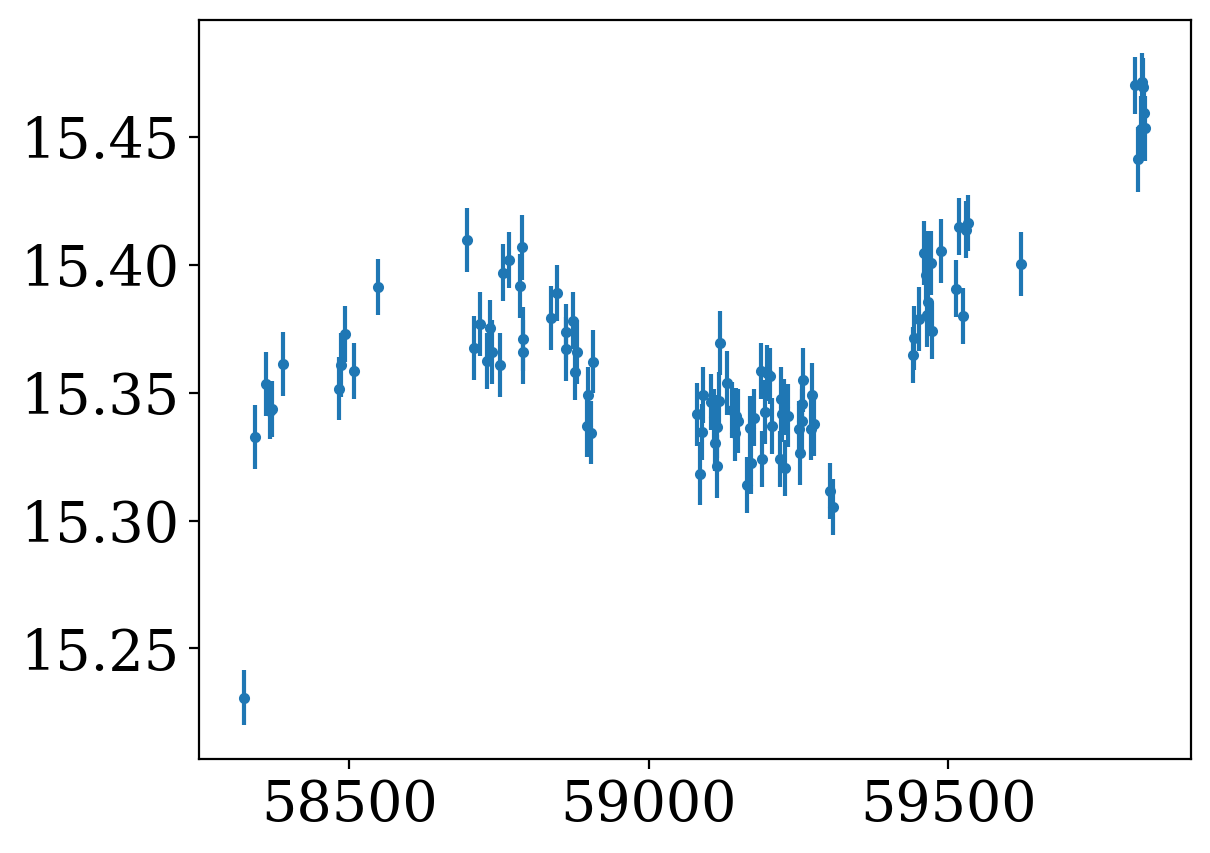

In [184]:
plt.errorbar(time, mag, magerr, fmt='.')

In [53]:
import astropy.stats as astro_stats
# Evaluate biweight location and scale
R, S = astro_stats.biweight.biweight_location(mag), astro_stats.biweight.biweight_scale(mag)

# Running deviation
running_deviation = dip_pipeline.deviation(mag, magerr, R, S)

## Time Series Calculations

In [569]:
column_names = ['Nphot',
    'biweight_scale',
    'frac_above_2_sigma',
    'Ndips',
    'rate',
    'chi2dof',
    'ADF_const',
    'ADF_const_trend',
    'ADF_pval_const',
    'ADF_pval_const_trend',
    'skew', 
    'kurtosis',
    'mad',
    'stetson_i',
    'stetson_j',
    'stetson_k',
    'invNeumann',
    'best_dip_power',
    'best_dip_time_loc',
    'best_dip_start',
    'best_dip_end',
    'best_dip_dt',
    'best_dip_ndet',
    'best_dip_score',
    'left_error',
    'right_error',
    'chi_square_gp',
    'gp_fun',
    'gp_status',
    'separation_btw_peaks',
    'closest_bright_star_arcsec',
    'closest_bright_star_mag',
    'closest_star_arcsec',
    'closest_star_mag',
    'density_arcsec2']

In [1027]:
sp = (demo_table['invNeumann'] > 3) & (demo_table['skew'] < -0.3) & (demo_table['Nphot']>150) & (demo_table['biweight_scale']<0.05)

In [1028]:
demo_table[sp]

,ra_gaia,dec_gaia,parallax_gaia,parallax_over_error_gaia,bp_rp_gaia,solution_id_gaia,source_id_gaia,pmra_gaia,pmra_error_gaia,pmdec_gaia,...,right_error,chi_square_gp,gp_fun,gp_status,separation_btw_peaks,closest_bright_star_arcsec,closest_bright_star_mag,closest_star_arcsec,closest_star_mag,density_arcsec2
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
695996941196066816,23.406345,41.105242,0.811814,24.851635,0.910048,1636148068921376768,347998458144403712,-5.066200,0.031558,-1.465650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
784311448305139712,3.968839,46.697797,2.950094,230.012700,0.985028,1636148068921376768,392155704110705664,41.812553,0.011166,-30.162144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
784508563287441408,4.166759,46.861682,1.700349,101.457924,0.910810,1636148068921376768,392254282200367616,-5.504149,0.013389,-0.922230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
858008384505380864,4.207439,59.367289,1.329483,31.679842,1.543503,1636148068921376768,429004187054875008,-0.397863,0.039466,-1.325506,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1070461277672833024,18.112526,72.597728,0.328957,6.611088,1.281156,1636148068921376768,535230616749303168,-2.269636,0.046876,-1.067001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970430729275834368,115.128428,53.424080,0.813264,14.911809,1.277504,1636148068921376768,985215336781250176,-3.782388,0.048693,-7.433780,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2855046234010288128,252.403643,56.258249,1.429676,46.474570,1.498006,1636148068921376768,1427523094831055744,-4.374589,0.038866,-28.820470,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3716032273150115840,312.854858,29.272837,1.126091,25.168804,1.603834,1636148068921376768,1858016119416485760,7.803181,0.030449,-0.511013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3716909387487379456,314.536747,29.740751,1.979215,46.373940,1.280970,1636148068921376768,1858454682812386560,-6.939482,0.035536,-1.720649,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(-2.0, 2.0)

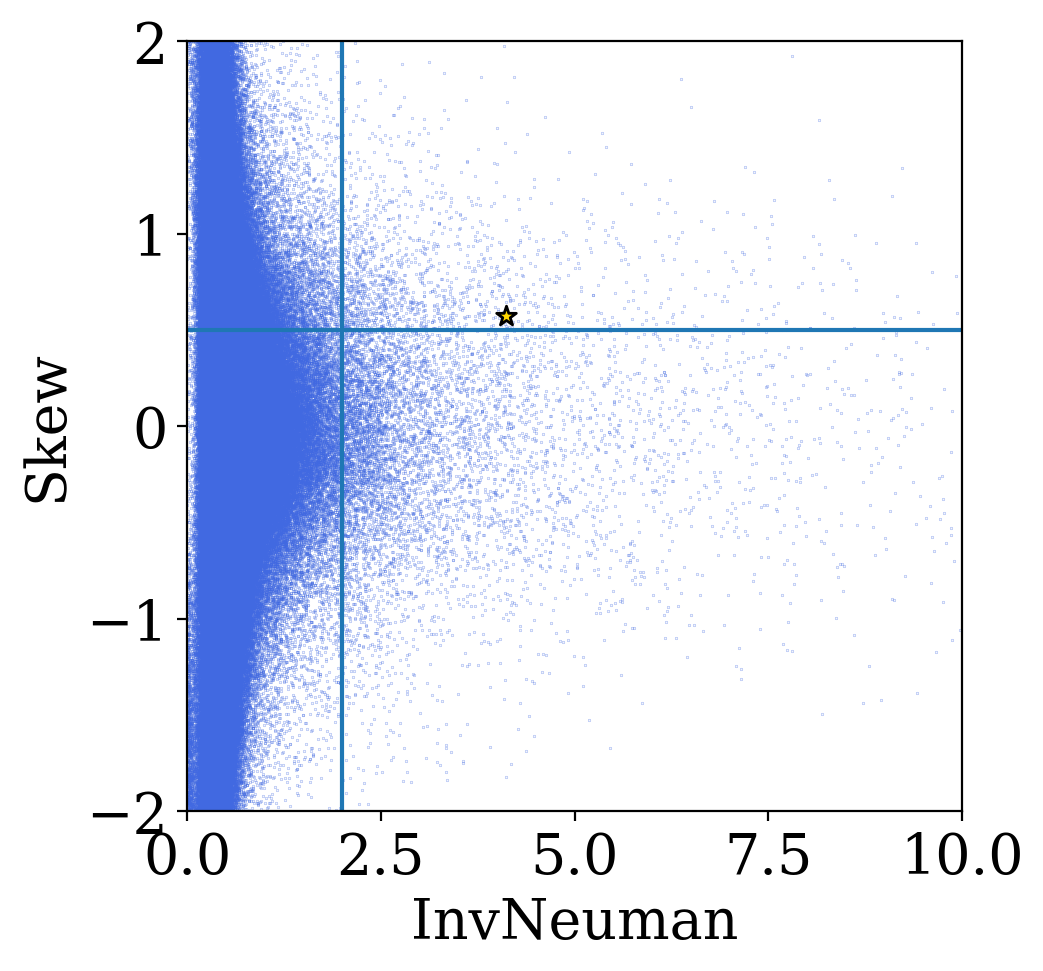

In [1017]:
plt.figure(figsize=(5,5))
plt.scatter(demo_table['invNeumann'],(demo_table['skew']), s=0.01, color='royalblue')


plt.scatter(demo_table.loc[106670401437827072]['invNeumann'], 
           demo_table.loc[106670401437827072]['skew'], s=55, color='gold', marker='*', edgecolor='k')

plt.axvline(2)
plt.axhline(0.5)
plt.xlim(0, 10)
plt.ylabel("Skew")
plt.xlabel("InvNeuman")
plt.ylim(-2, 2)


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-2.0, 4.1)

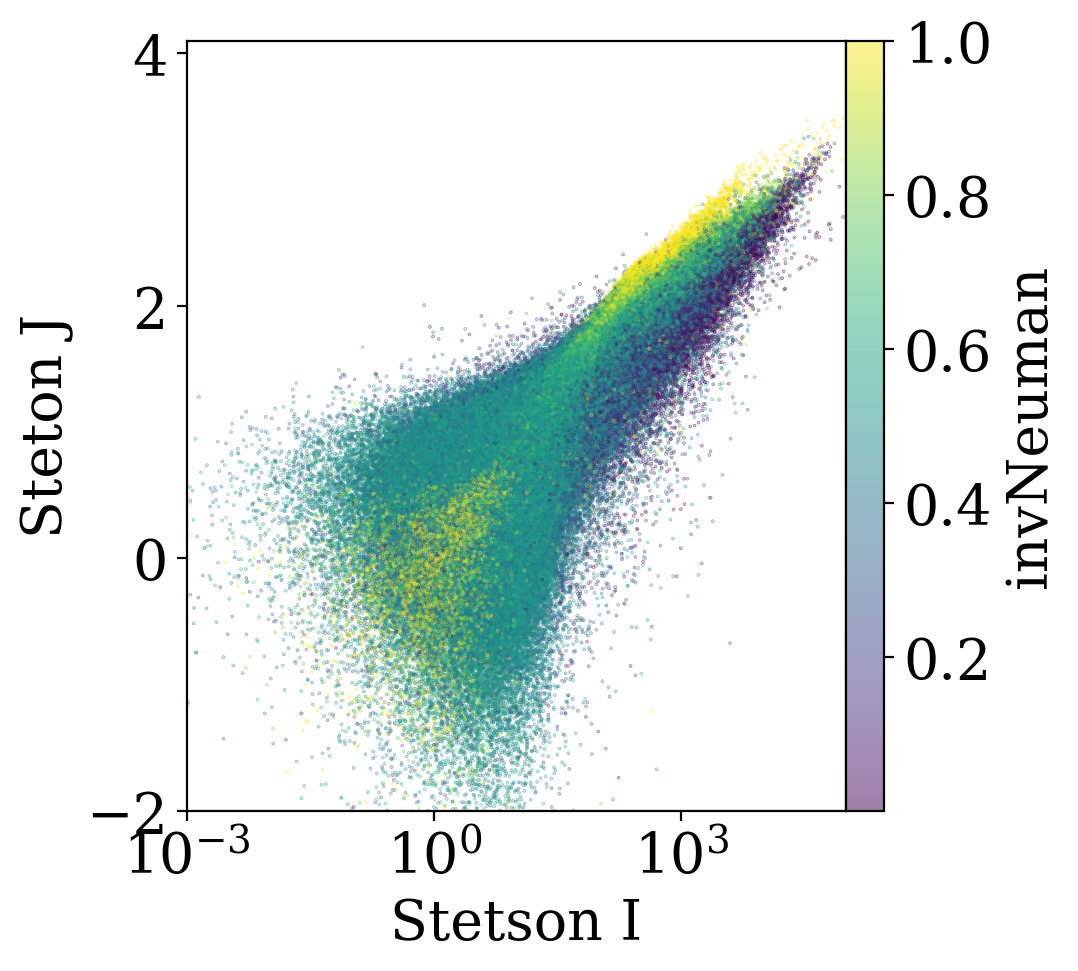

In [948]:
plt.figure(figsize=(5,5))
plt.scatter((demo_table['stetson_i']),
            np.log10(demo_table['stetson_j']), 
            s=0.1, alpha=0.5, c=demo_table['invNeumann'], 
           vmin=0.001, vmax=1)
plt.xscale('log')
plt.ylabel("Steton J")
plt.xlabel("Stetson I")
plt.colorbar(label='invNeuman', pad=0.0001)
plt.xlim(1e-3, 1e5)
plt.ylim(-2, 4.1)

### Test `Evaluate` on a single light curve

In [ ]:
len(lc['mjd_ztf_source'].values)

In [149]:
print (evaluate(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'], lc['ra_ztf_source'].values[0], 
        lc['dec_ztf_source'].values[0]))

Nphot                        NaN
biweight_scale               NaN
frac_above_2_sigma           NaN
Ndips                        NaN
rate                         NaN
chi2dof                      NaN
ADF_const                    NaN
ADF_const_trend              NaN
ADF_pval_const               NaN
ADF_pval_const_trend         NaN
skew                         NaN
kurtosis                     NaN
mad                          NaN
stetson_i                    NaN
stetson_j                    NaN
stetson_k                    NaN
invNeumann                   NaN
best_dip_power               NaN
best_dip_time_loc            NaN
best_dip_start               NaN
best_dip_end                 NaN
best_dip_dt                  NaN
best_dip_ndet                NaN
best_dip_score               NaN
left_error                   NaN
right_error                  NaN
chi_square_gp                NaN
gp_fun                       NaN
gp_status                    NaN
separation_btw_peaks         NaN
closest_br

## Batch Calculation

In [570]:
# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=column_names, dtype=float)

In [571]:
%%time
# apply calc_biweight function
calc_ = ens.batch(
    evaluate,
    'mjd_ztf_source', 'mag_ztf_source', 
    'magerr_ztf_source', 'catflags_ztf_source',
    'band_ztf_source', 'ra_ztf_source', 
    'dec_ztf_source',
    meta=my_meta,
    use_map=True)

Using generated label, result_1, for a batch result.
CPU times: user 702 ms, sys: 100 ms, total: 803 ms
Wall time: 727 ms


In [572]:
%%time
ens.object.join(calc_).update_ensemble()

Task exception was never retrieved
future: <Task finished name='Task-439441723' coro=<Client._gather.<locals>.wait() done, defined at /epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit


CPU times: user 11.2 s, sys: 2.28 s, total: 13.5 s
Wall time: 12.3 s


In [72]:
ens.object # confirm lazy

,ra_gaia,dec_gaia,parallax_gaia,parallax_over_error_gaia,bp_rp_gaia,solution_id_gaia,source_id_gaia,pmra_gaia,pmra_error_gaia,pmdec_gaia,pmdec_error_gaia,parallax_error_gaia,phot_g_mean_mag_gaia,l_gaia,b_gaia,non_single_star_gaia,classprob_dsc_combmod_galaxy_gaia,classprob_dsc_combmod_star_gaia,in_qso_candidates_gaia,teff_gspphot_gaia,teff_gspphot_upper_gaia,teff_gspphot_lower_gaia,logg_gspphot_gaia,logg_gspphot_lower_gaia,logg_gspphot_upper_gaia,mh_gspphot_gaia,mh_gspphot_lower_gaia,mh_gspphot_upper_gaia,distance_gspphot_gaia,distance_gspphot_lower_gaia,distance_gspphot_upper_gaia,azero_gspphot_gaia,azero_gspphot_lower_gaia,azero_gspphot_upper_gaia,ag_gspphot_gaia,ebpminrp_gspphot_gaia,ebpminrp_gspphot_lower_gaia,ebpminrp_gspphot_upper_gaia,Norder_gaia,Npix_gaia,Dir_gaia,ps1_objid_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,ps1_gMeanPSFMag_ztf_dr14,ps1_rMeanPSFMag_ztf_dr14,ps1_iMeanPSFMag_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_DIST,Norder,Dir,Npix,biweight_scale,frac_above_2_sigma,Ndips,rate,chi2dof,ADF_const,ADF_const_trend,ADF_pval_const,ADF_pval_const_trend,skew,kurtosis,mad,stetson_i,stetson_j,stetson_k,invNeumann,best_dip_power,best_dip_time_loc,best_dip_start,best_dip_end,best_dip_dt,best_dip_ndet,best_dip_score,left_error,right_error,chi_square_gp,gp_fun,gp_status,separation_btw_peaks,closest_bright_star_arcsec,closest_bright_star_mag,closest_star_arcsec,closest_star_mag,density_arcsec2
npartitions=287277,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
281474976710656,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13833861786631143424,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
%%time
demo_table = ens.object.head(4_833_834, npartitions=140_050)

In [1]:
#demo_table

In [882]:
qs = (demo_table['stetson_i']>5) & ( demo_table['invNeumann'] > 1.6) &\
(demo_table['skew']>1.5)  & (demo_table['Nphot']>70)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 15.1 s, sys: 2.68 s, total: 17.8 s
Wall time: 17 s


(16.195947506511583, 14.989767540199683)

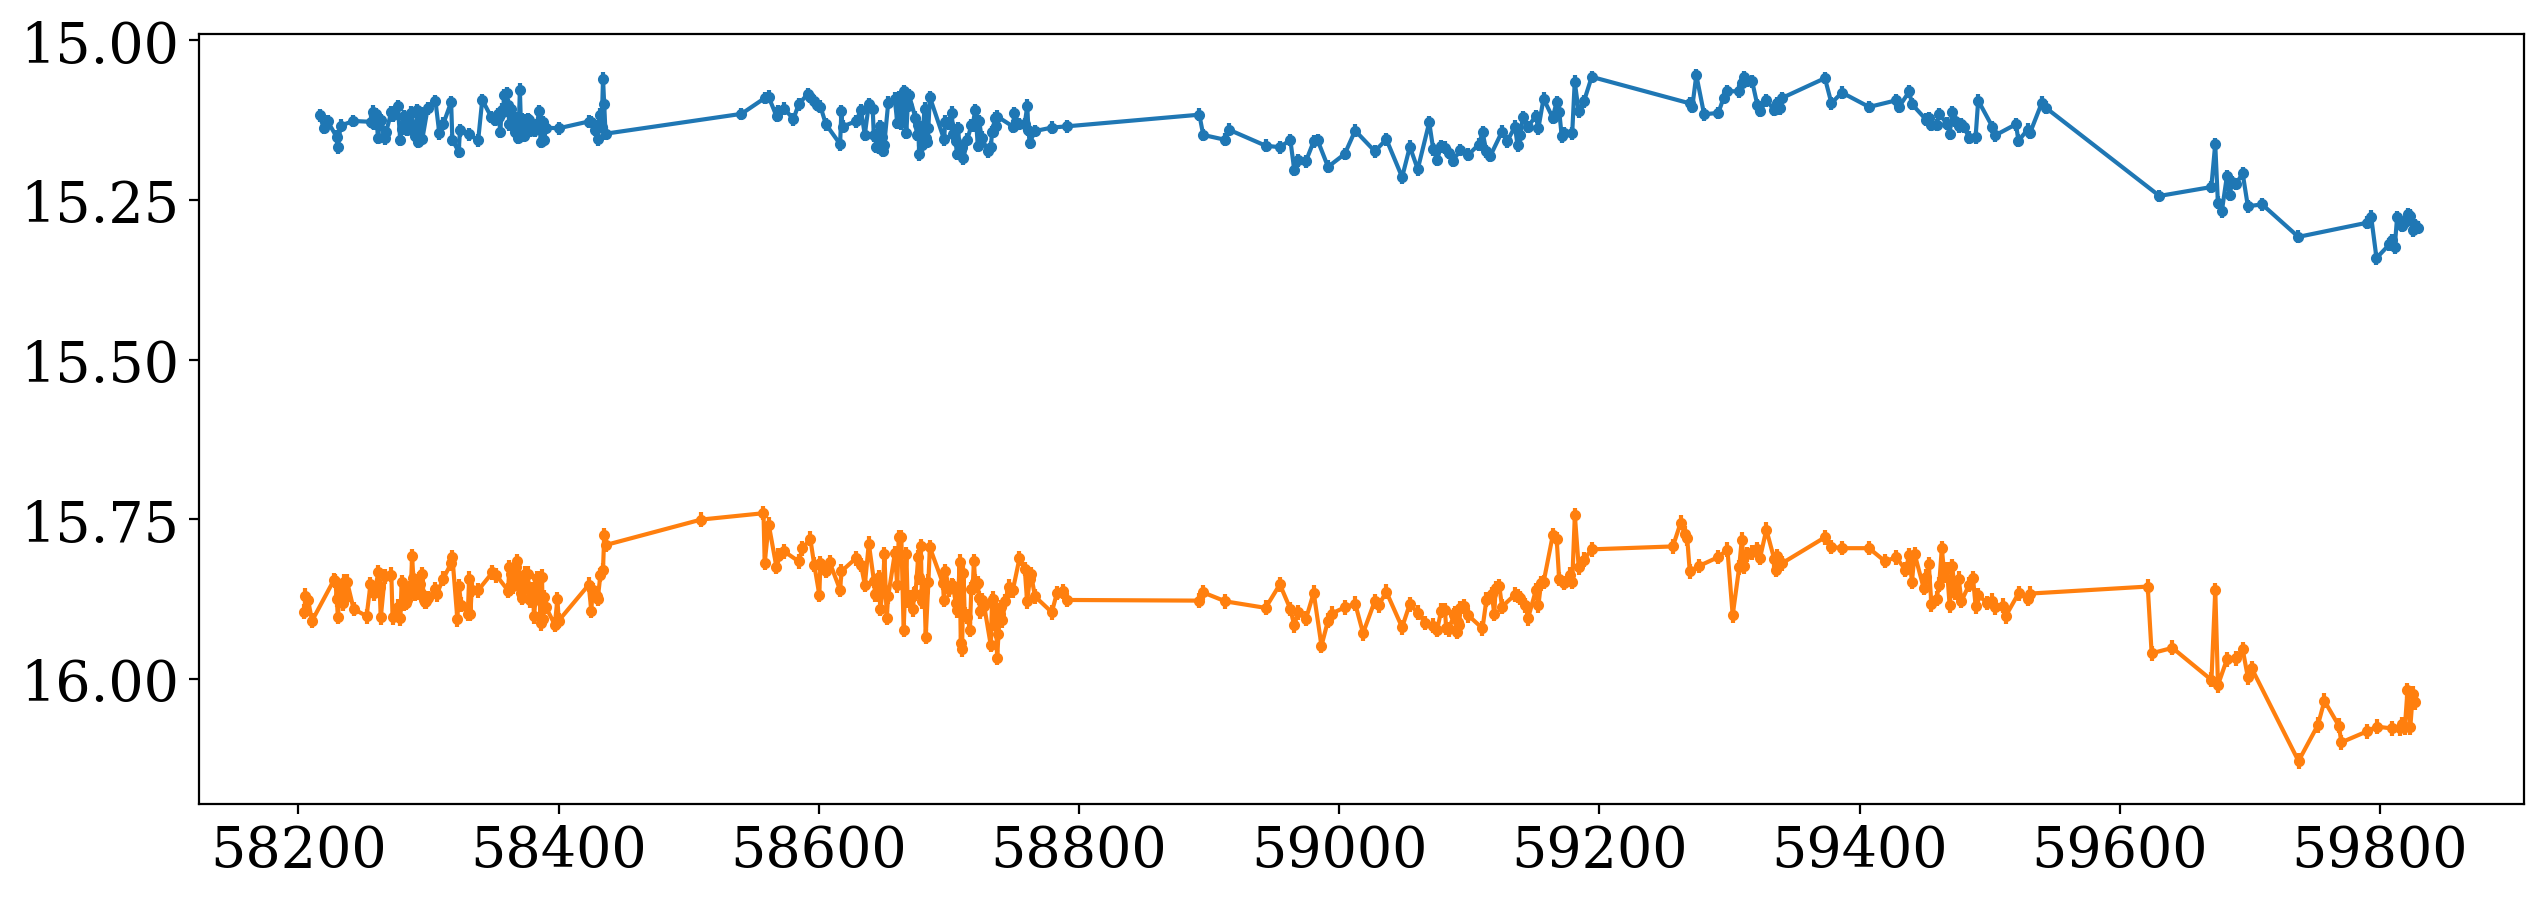

In [886]:
%%time
# know dipper
lc = ens.source.loc[4258571364073472000]
lc = lc.compute()

time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'].values, band_of_study='r', flag_good=0)

timeg, magg, magerrg = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'].values, band_of_study='g', flag_good=0)


plt.figure(figsize=(15,5))
plt.errorbar(time, mag, magerr, fmt='.-')
plt.errorbar(timeg, magg, magerrg, fmt='.-')
plt.ylim(plt.ylim()[::-1])

In [887]:
lc

,ra_gaia_andy_fg_dwarfs,dec_gaia_andy_fg_dwarfs,parallax_gaia_andy_fg_dwarfs,parallax_over_error_gaia_andy_fg_dwarfs,bp_rp_gaia_andy_fg_dwarfs,solution_id_gaia_andy_fg_dwarfs,source_id_gaia_andy_fg_dwarfs,pmra_gaia_andy_fg_dwarfs,pmra_error_gaia_andy_fg_dwarfs,pmdec_gaia_andy_fg_dwarfs,...,catflags_ztf_source,fieldID_ztf_source,mag_ztf_source,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
4258571364073472000,291.997634,48.365404,1.359617,69.78419,1.226915,1636148068921376768,2129285669709552896,-8.337955,0.021916,-18.412436,...,0,766,15.753067,0.011334,58707.43186,43,g,8,240000,242071
4258571364073472000,291.997634,48.365404,1.359617,69.78419,1.226915,1636148068921376768,2129285669709552896,-8.337955,0.021916,-18.412436,...,0,766,15.816545,0.011447,58708.23834,43,g,8,240000,242071
4258571364073472000,291.997634,48.365404,1.359617,69.78419,1.226915,1636148068921376768,2129285669709552896,-8.337955,0.021916,-18.412436,...,0,766,15.817039,0.011448,58707.40577,43,g,8,240000,242071
4258571364073472000,291.997634,48.365404,1.359617,69.78419,1.226915,1636148068921376768,2129285669709552896,-8.337955,0.021916,-18.412436,...,0,766,15.871119,0.011550,58707.23711,43,g,8,240000,242071
4258571364073472000,291.997634,48.365404,1.359617,69.78419,1.226915,1636148068921376768,2129285669709552896,-8.337955,0.021916,-18.412436,...,0,766,15.836437,0.011484,58711.26336,43,g,8,240000,242071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4258571364073472000,291.997634,48.365404,1.359617,69.78419,1.226915,1636148068921376768,2129285669709552896,-8.337955,0.021916,-18.412436,...,0,766,15.825758,0.011464,59392.26731,43,g,8,240000,242071
4258571364073472000,291.997634,48.365404,1.359617,69.78419,1.226915,1636148068921376768,2129285669709552896,-8.337955,0.021916,-18.412436,...,0,766,15.817475,0.011449,59394.34629,43,g,8,240000,242071
4258571364073472000,291.997634,48.365404,1.359617,69.78419,1.226915,1636148068921376768,2129285669709552896,-8.337955,0.021916,-18.412436,...,0,766,15.784493,0.011389,59396.30135,43,g,8,240000,242071


In [816]:
q = (demo_table['Nphot']>10) & (demo_table['Ndips']>0) &\
 (demo_table['best_dip_power']>1) &\
 (demo_table['best_dip_ndet']>3) & \
(demo_table['best_dip_end'] - demo_table['best_dip_start'] > 5) & (demo_table['invNeumann'] >1) &\
(demo_table['closest_star_arcsec']*1e5>2) & (demo_table['closest_star_mag']>16)

In [817]:
demo_table[q]

,ra_gaia,dec_gaia,parallax_gaia,parallax_over_error_gaia,bp_rp_gaia,solution_id_gaia,source_id_gaia,pmra_gaia,pmra_error_gaia,pmdec_gaia,...,right_error,chi_square_gp,gp_fun,gp_status,separation_btw_peaks,closest_bright_star_arcsec,closest_bright_star_mag,closest_star_arcsec,closest_star_mag,density_arcsec2
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
1802273228874317824,123.177713,31.945798,0.529296,5.934052,1.463215,1636148068921376768,901136610317370880,4.007816,0.106808,-2.623290,...,0.000000,17.058116,1.0,1.253486e-06,5.994790,0.004500,15.917324,0.000024,17.291197,12600.030976
2229305609436528640,105.111483,72.756228,0.427223,9.458374,0.951830,1636148068921376768,1114652800541152128,0.218686,0.035046,3.823240,...,0.000000,8.465105,1.0,9.330228e-07,0.000000,0.014589,12.760692,0.000034,16.637754,10309.116253
3648239053502939136,295.900553,17.877325,0.510420,6.361132,1.416580,1636148068921376768,1824119511659387136,-1.758277,0.073178,-5.343979,...,6.614955,17.137838,1.0,3.202566e-06,0.000000,0.009944,11.129726,0.000028,16.934637,504001.239059
3923494129467654144,332.575074,43.688912,0.495513,9.841995,1.050600,1636148068921376768,1961747035669417344,0.443174,0.044060,-2.238576,...,0.000000,29.734607,1.0,1.136081e-06,4.011400,0.012633,10.319693,0.000024,16.826248,49254.666544
3926920027042742272,333.772208,47.149808,0.522747,13.253737,0.948159,1636148068921376768,1963460006070786432,-1.494384,0.043305,0.639070,...,0.000000,29.483567,1.0,7.833783e-07,4.008550,0.012893,12.167783,0.000022,16.322731,82472.930028
3971951399163396096,345.496914,50.241615,0.405607,7.668943,0.860153,1636148068921376768,1985975702104298624,-2.384622,0.051609,-3.110604,...,31.682051,33.907044,1.0,8.913019e-07,-7.977970,0.012428,11.856078,0.000023,16.731750,63000.154882
4047009306271285248,289.188654,25.025112,0.443660,9.107895,1.524125,1636148068921376768,2023504645322072192,-0.735488,0.032067,-9.362067,...,34.389284,38.255674,1.0,1.282367e-06,-9.909520,0.001419,13.109762,0.000023,16.597010,211909.611877
4050373985509048320,294.794587,27.535682,0.536608,9.430385,1.502982,1636148068921376768,2025186966868534528,-1.447065,0.044597,-7.494267,...,0.004784,7.991167,1.0,2.781750e-02,-0.216263,0.010476,11.989896,0.000022,16.670723,460473.859322
4078931319013244928,288.688683,30.521187,0.405471,9.564418,1.017412,1636148068921376768,2039465637129234048,-0.358376,0.038359,-7.002576,...,27.017999,29.570509,1.0,7.475924e-07,-6.103160,0.016259,11.955539,0.000023,16.512358,96218.418366


In [540]:
%%time
# know dipper
lc = ens.source.loc[15411730515492864]
lc = lc.compute()

time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'].values, band_of_study='r', flag_good=0)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 21.1 s, sys: 4.3 s, total: 25.4 s
Wall time: 23.7 s


In [541]:
demo_table[q].head(5)['best_dip_time_loc']

_hipscat_index
9207088676864000     58486.12740
12593992189345792    58700.44185
13021147805253632    58372.48923
15256369791762432    59461.47298
15411730515492864    59429.47169
Name: best_dip_time_loc, dtype: float64

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 20.7 s, sys: 3.54 s, total: 24.3 s
Wall time: 22.8 s


(15.748524840176106, 14.981847856938838)

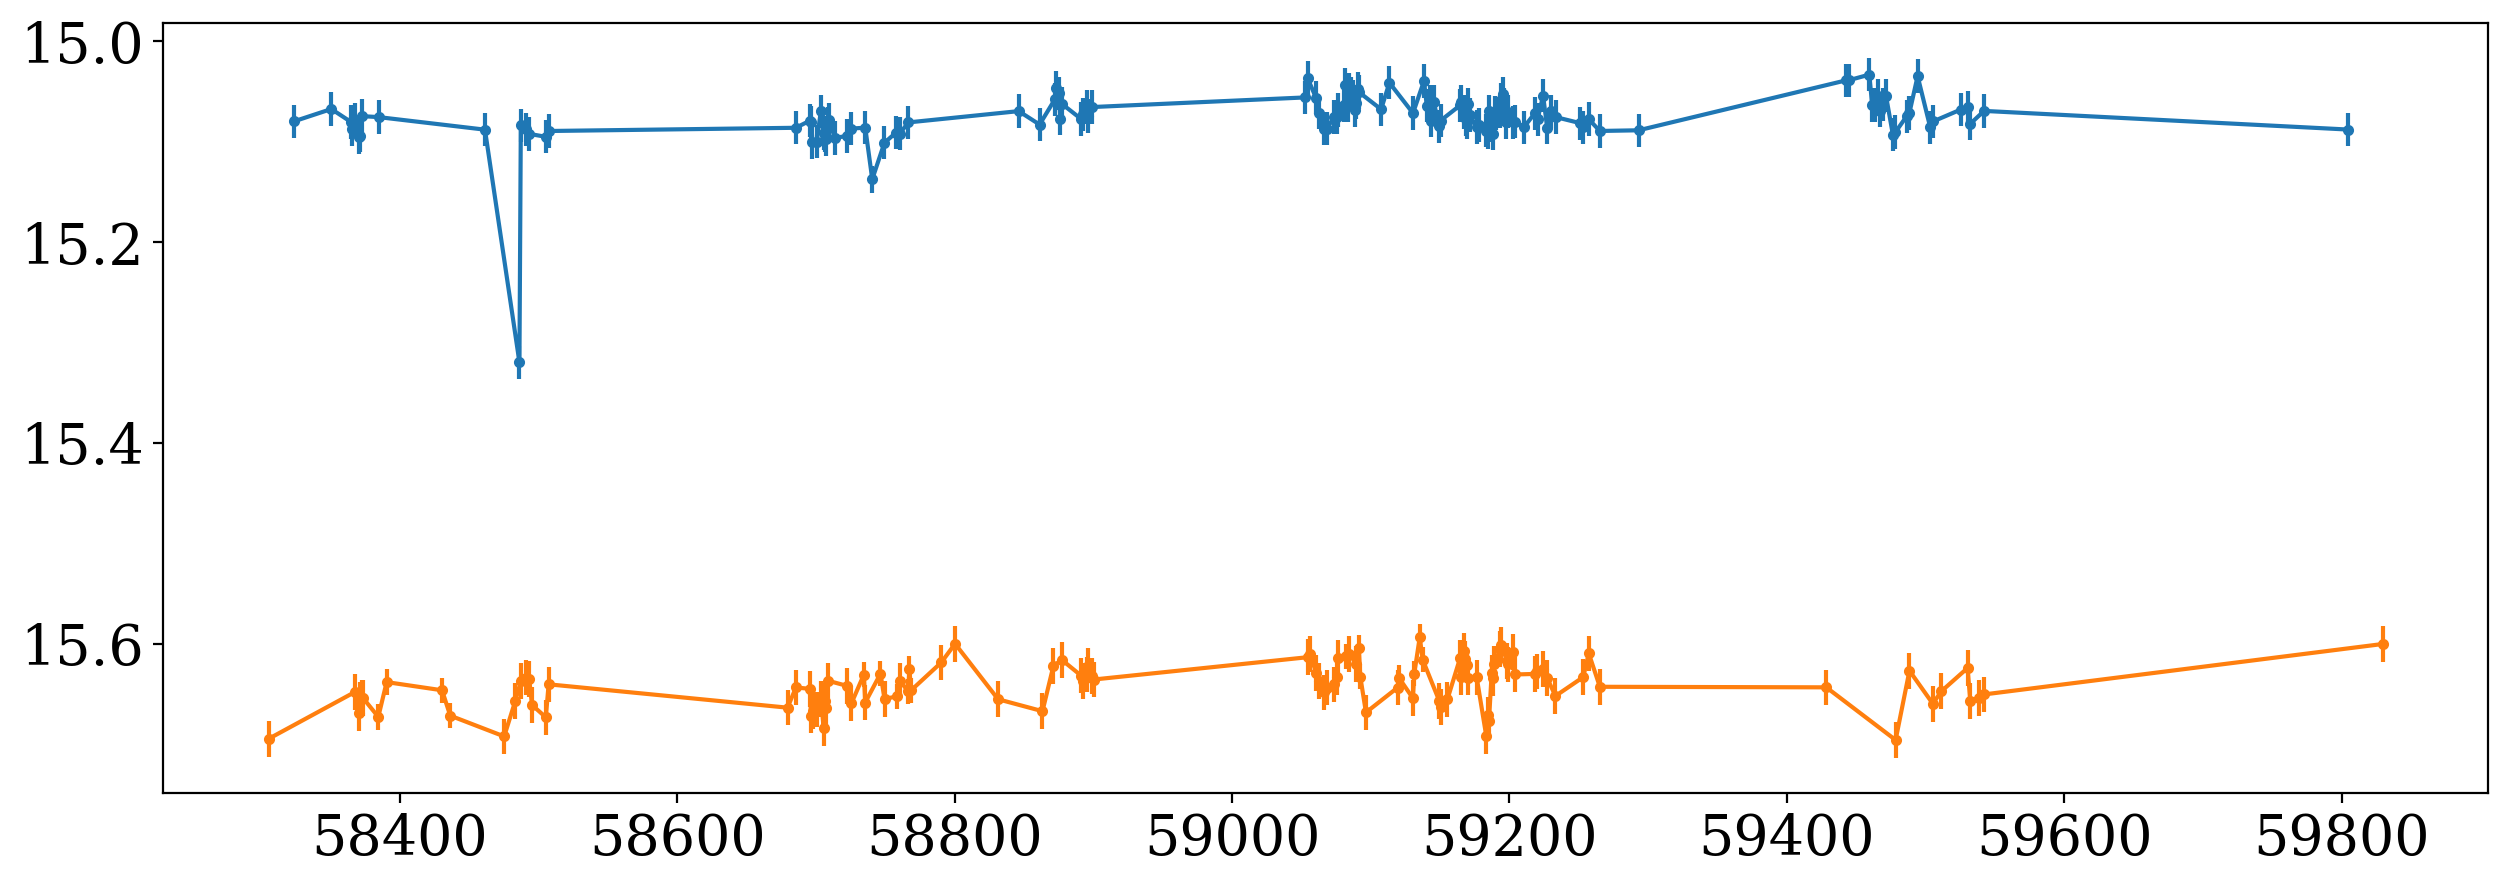

In [438]:
%%time
# know dipper
lc = ens.source.loc[9207088676864000]
lc = lc.compute()

time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'].values, band_of_study='r', flag_good=0)

timeg, magg, magerrg = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'].values, band_of_study='g', flag_good=0)


plt.figure(figsize=(15,5))
plt.errorbar(time, mag, magerr, fmt='.-')
plt.errorbar(timeg, magg, magerrg, fmt='.-')
plt.ylim(plt.ylim()[::-1])